## Based on the followings:
* http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
* http://adventuresinmachinelearning.com/keras-lstm-tutorial/
* https://machinelearningmastery.com/configure-encoder-decoder-model-neural-machine-translation/
* https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/
* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
* https://github.com/farizrahman4u/seq2seq
* https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

## TODO
* ~~look into categorical representation~~
* ~~look into the number of missing words over the total~~
* ~~look into different models (attention, hierachical, etc.)~~
* look into attention

In [1]:
import os
import re
import numpy as np
import glob
import pickle as pkl
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import time

from string import punctuation
from itertools import islice
from gensim.models import KeyedVectors
from keras.models import Model
from keras.layers import Layer, Input, LSTM, GRU, Dense, Masking, Embedding, Activation, TimeDistributed
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

from sklearn.model_selection import KFold

c:\users\daniele\appdata\local\conda\conda\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\daniele\appdata\local\conda\conda\envs\ml\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
DATA_PATH = 'data'
OUTPUT_PATH = 'output'
punct = set(punctuation)
file_list = sorted(glob.glob('data/parsed/*.txt'))

In [3]:
w2v = KeyedVectors.load_word2vec_format(os.path.join(DATA_PATH, 'GoogleNews-vectors-negative300.bin.gz'), binary=True)

In [3]:
# re-load params
with open(os.path.join(DATA_PATH, 'data_20k.pkl'), 'rb') as data_file, open(os.path.join(DATA_PATH, 'params_20k.pkl'), 'rb') as params_file:
    data = pkl.load(data_file)
    params = pkl.load(params_file)
    tokenizer = params['tokenizer']
    index_word = params['index_word']
    embedding_matrix = params['W']
    missing_words = params['missing_words']

In [4]:
embedding_dim = 300#w2v.vector_size
eos_token = 'EOS'
unk_token = 'UNK'
eos_vector = np.ones((embedding_dim))
unk_vector = np.zeros((embedding_dim))

In [5]:
def preprocess(text):
    text = re.sub(repl='', string=text, pattern='^> ') # remove starting caret, if any
    text = re.sub(repl='\g<1> \g<2>', string=text, pattern='(\w+)-(\w+)') # compound words    
    text = re.sub(repl=' ', string=text, pattern='-{2,}|\s{2,}|[%s\t\n/]' % (''.join(punctuation)))
#     text = re.sub(repl=' digits ', string=text, pattern='^\d+$| \d+| \d+ ') # replace digits with a standard 'digits' word
    return text

def read_corpus(file_list):
    corpus = []
    for file in file_list:
        with open(file, 'r', encoding='utf-8') as f:
            print('read_corpus: processing [{}]'.format(file))
            corpus.append(f.read())
            
    return corpus
            
def build_vocabulary(corpus, num_words, oov_token):
    tokenizer = Tokenizer(num_words=num_words+1, oov_token=oov_token) # +1 for the oov token
    tokenizer.fit_on_texts(corpus)
    
    # Fix keras' nasty behaviour. See https://github.com/keras-team/keras/issues/8092
    # Only include words found in w2v
    tokenizer.word_index = {w:i for  w,i in tokenizer.word_index.items() 
                                if   i <= num_words} # <= because tokenizer is 1 indexed (this will leave out UNK)
    tokenizer.num_words = num_words + 2  # UNK + EOS
    tokenizer.word_index[oov_token] = len(tokenizer.word_index) + 1
    tokenizer.word_index[eos_token] = len(tokenizer.word_index) + 1
    index_word = [None for i in range(len(tokenizer.word_index) + 1)]  # index is 1-based
    for w,i in tokenizer.word_index.items():
        index_word[i] = w
    
    return tokenizer, index_word

def prepare_data(corpus, tokenizer):
    # Still go through the files line by line, as we want to predict the next scene, 
    # not just the next sentence
    data = []
    for i, doc in enumerate(corpus):
        doc_data = []
        print('prepare_data: processing [{}]'.format(file_list[i]))
        
        for j, line in enumerate(doc.split('\n')):
            if len(line) == 0:
                print('Line {} is empty. Replacing with "empty line".'.format(j+1))
                line = 'empty line'

            tokenized_line = tokenizer.texts_to_sequences([line])[0]
            if len(tokenized_line) == 0:
                tokenized_line = tokenizer.texts_to_sequences(['empty line'])[0]
                
            doc_data.append(tokenized_line)

        if len(doc_data) == 0:
            print('File {} has no data'.format(file_list[i]))
        else:
            data.append(doc_data)
        
    return data

def get_embeddings(word_index, w2v, unk_vector):
    embedding_matrix=np.zeros(shape=(len(word_index)+1, w2v.vector_size))  # +1 as keras' tokenizer is 1-based
    missing_words = []
    for word,i in word_index.items():
        if word not in w2v:
            # Try to capitalize it
            if word.capitalize() not in w2v:
                missing_words.append(word)
                embedding_matrix[i] = unk_vector
            else:
                embedding_matrix[i] = w2v[word.capitalize()]
        else:
            embedding_matrix[i] = w2v[word]
    
    # add EOS token and oov_tokens
    embedding_matrix[-1] = eos_vector # keras' index the vocab starting from 1
    embedding_matrix[-2] = unk_vector
    return embedding_matrix, missing_words

In [6]:
corpus = read_corpus(file_list)
tokenizer, index_word = build_vocabulary(corpus, num_words=20000, oov_token=unk_token)
embedding_matrix, missing_words = get_embeddings(tokenizer.word_index, w2v, unk_vector)

read_corpus: processing [data/parsed/parsed-12heads.txt]
read_corpus: processing [data/parsed/parsed-1893.txt]
read_corpus: processing [data/parsed/parsed-20160221-thesueno-utf8.txt]
read_corpus: processing [data/parsed/parsed-20160221-thesueno.txt]
read_corpus: processing [data/parsed/parsed-3card-deadmanshill-2016Ap24.txt]
read_corpus: processing [data/parsed/parsed-69krakatoa.txt]
read_corpus: processing [data/parsed/parsed-905-shrapnel.txt]
read_corpus: processing [data/parsed/parsed-abno.txt]
read_corpus: processing [data/parsed/parsed-acg-crossbow.txt]
read_corpus: processing [data/parsed/parsed-acitw.txt]
read_corpus: processing [data/parsed/parsed-actofmurder.txt]
read_corpus: processing [data/parsed/parsed-adverbum.txt]
read_corpus: processing [data/parsed/parsed-afdfr.txt]
read_corpus: processing [data/parsed/parsed-afflicted.txt]
read_corpus: processing [data/parsed/parsed-allthingsdevours.txt]
read_corpus: processing [data/parsed/parsed-aotearoa.txt]
read_corpus: processing

read_corpus: processing [data/parsed/parsed-primrose-edited.txt]
read_corpus: processing [data/parsed/parsed-progressive1.txt]
read_corpus: processing [data/parsed/parsed-punkpoints.txt]
read_corpus: processing [data/parsed/parsed-rameses.txt]
read_corpus: processing [data/parsed/parsed-recluse.txt]
read_corpus: processing [data/parsed/parsed-represso.txt]
read_corpus: processing [data/parsed/parsed-revolution-buny.txt]
read_corpus: processing [data/parsed/parsed-robot.txt]
read_corpus: processing [data/parsed/parsed-rogue.txt]
read_corpus: processing [data/parsed/parsed-roofed-alien.txt]
read_corpus: processing [data/parsed/parsed-rover.txt]
read_corpus: processing [data/parsed/parsed-samfortune.txt]
read_corpus: processing [data/parsed/parsed-santaland.txt]
read_corpus: processing [data/parsed/parsed-saugusnet-a.txt]
read_corpus: processing [data/parsed/parsed-saugusnet-b.txt]
read_corpus: processing [data/parsed/parsed-saugusnet-c.txt]
read_corpus: processing [data/parsed/parsed-sca

In [14]:
print('Vocabulary size:', tokenizer.num_words)
print('OOV token index:', tokenizer.word_index[unk_token])
print('EOS token index:', tokenizer.word_index[eos_token])

Vocabulary size: 20002
OOV token index: 20001
EOS token index: 20002


In [15]:
# text = 'Sample sentence with a possible balabiut token and some 1984 plus sentry'
# print(preprocess(text))
# print(prepare_input(text, tokenizer))
vocab_size = len(embedding_matrix)
unk_index = tokenizer.word_index[unk_token]
eos_index = unk_index+1
print('Embedding matrix size:', embedding_matrix.shape)
print('Unique words found (UNK, EOS + vocab):', len(tokenizer.word_index))
print('Of which missing words (no embeddings):', len(missing_words))

Embedding matrix size: (20003, 300)
Unique words found (UNK, EOS + vocab): 20002
Of which missing words (no embeddings): 1562


In [9]:
data = prepare_data(corpus, tokenizer)

prepare_data: processing [data/parsed/parsed-12heads.txt]
prepare_data: processing [data/parsed/parsed-1893.txt]
prepare_data: processing [data/parsed/parsed-20160221-thesueno-utf8.txt]
Line 243 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-20160221-thesueno.txt]
prepare_data: processing [data/parsed/parsed-3card-deadmanshill-2016Ap24.txt]
prepare_data: processing [data/parsed/parsed-69krakatoa.txt]
prepare_data: processing [data/parsed/parsed-905-shrapnel.txt]
prepare_data: processing [data/parsed/parsed-abno.txt]
prepare_data: processing [data/parsed/parsed-acg-crossbow.txt]
Line 1650 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-acitw.txt]
prepare_data: processing [data/parsed/parsed-actofmurder.txt]
prepare_data: processing [data/parsed/parsed-adverbum.txt]
prepare_data: processing [data/parsed/parsed-afdfr.txt]
prepare_data: processing [data/parsed/parsed-afflicted.txt]
prepare_data: processing [data/parse

prepare_data: processing [data/parsed/parsed-newernewyear.txt]
prepare_data: processing [data/parsed/parsed-newyearsspeed-jan16a.txt]
prepare_data: processing [data/parsed/parsed-newyearsspeed-jan16b.txt]
prepare_data: processing [data/parsed/parsed-newyearsspeed-jan9.txt]
Line 27 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-newyearsspeed.txt]
prepare_data: processing [data/parsed/parsed-newyearsspeed08.txt]
prepare_data: processing [data/parsed/parsed-nightfall.txt]
prepare_data: processing [data/parsed/parsed-nightfall2.txt]
prepare_data: processing [data/parsed/parsed-nordandbert.txt]
prepare_data: processing [data/parsed/parsed-oad.txt]
prepare_data: processing [data/parsed/parsed-oneeyeopen.txt]
Line 36 is empty. Replacing with "empty line".
prepare_data: processing [data/parsed/parsed-onehalf.txt]
prepare_data: processing [data/parsed/parsed-orevore.txt]
prepare_data: processing [data/parsed/parsed-park.txt]
prepare_data: processing [data/pa

In [10]:
# save various objects for later reuse
with open(os.path.join(DATA_PATH, 'data_20k.pkl'), 'wb') as data_file, open(os.path.join(DATA_PATH, 'params_20k.pkl'), 'wb') as params_file:
    params = {
        'tokenizer': tokenizer,
        'index_word': index_word,
        'W': embedding_matrix,
        'missing_words': missing_words
    }
    pkl.dump(data, data_file)
    pkl.dump(params, params_file)
    

In [7]:
def window(seq, n=3, step=1):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s[0],...s[n-1]), (s[0+skip_n],...,s[n-1+skip_n]), ...   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    

    result = result[step:]
    for elem in it:
        result = result + (elem,)
        if len(result) == n:
            yield result
            result = result[step:]

def create_samples(data, test_split=0.1, shuffle=False, max_seq_length=None):    
    samples = []
    for i, play in enumerate(data):
        if max_seq_length is not None:
            chunks = [line[offset:offset+max_seq_length] 
                      for line in play 
                      for offset in range(0, len(line), max_seq_length)]
        else:
            chunks = play
            
        for scene, command, reply in window(chunks, n=3, step=2):
            samples.append((scene, command, reply))
#             if max_seq_length is not None:
#                 sub_scenes  = [scene[offset:offset+max_seq_length]   
#                                for offset in range(0, len(scene), max_seq_length)]
#                 sub_replies = [reply[offset:offset+max_seq_length]   
#                                for offset in range(0, len(reply), max_seq_length)]
                
#                 # sample as many triples as possible
# #                 scenes   = sub_scenes[np.random.choice(0, range(len(sub_scenes)), len(sub_scenes)//max_seq_length)]
# #                 commands = sub_cmds[np.random.choice(range(len(sub_cmds)), len(sub_cmds)//max_seq_length)]
# #                 replies   = sub_replies[np.random.choice(range(len(sub_replies)), len(sub_replies)//max_seq_length)]
                
#                 for s in sub_scenes:
#                     for r in sub_replies:
#                         samples.append((s, command, r))
                
# #             if len(command) > 10:
# #                 command_line = ' '.join([index_word[idx] for idx in command])
# #                 print('Found anomalous command for play {} [{}] with length {}: [{}]'.format(
# #                     i, os.path.basename(file_list[i]), len(command), command_line))
#             else:
#                 samples.append((scene, command, reply))
    
    if shuffle:
        np.random.shuffle(samples)
        
    if test_split is not None:
        split = int((1-test_split) * len(samples))
        train_samples = samples[:split]
        test_samples = samples[split:]
        return train_samples, test_samples
    
    return samples

In [8]:
# Define a batch generator
class BatchGenerator(object):
    def __init__(self, data, vocab_size, batch_size=1, reverse_input=False, shuffle=True, max_seq_length=None):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.vocab_size = vocab_size
        self.reverse_input = reverse_input
        self.max_seq_length = max_seq_length
        self.UNK = unk_index
        self.EOS = eos_index
        self.PAD = 0
        
    def generate_batch(self): 
        # every three lines comprise a sample sequence where the first two items
        # are the input and the last one is the output
        i  = 1 # batch counter        
        x_enc = []
        x_dec = []
        y  = []
            
        while True:
            if self.shuffle:
                np.random.shuffle(self.data)
            
            for j, (scene, command, reply) in enumerate(self.data):
                if self.reverse_input:
                    scene = scene[::-1]
                    
                encoder_input  = np.array(scene + command)
                decoder_input  = np.array([self.EOS] + reply)
                decoder_output = np.array(to_categorical(reply + [self.EOS], self.vocab_size))
                    
                x_enc.append(encoder_input)
                x_dec.append(decoder_input)
                y.append(decoder_output)
                
                if i == self.batch_size or j == len(data):
                    if self.batch_size > 1:
                        # pad and return the batch
                        x_enc = sequence.pad_sequences(x_enc, padding='post', value=self.PAD, maxlen=self.max_seq_length)
                        x_dec = sequence.pad_sequences(x_dec, padding='post', value=self.PAD, maxlen=self.max_seq_length)    
                        y     = sequence.pad_sequences(y, padding='post', value=self.PAD, maxlen=self.max_seq_length)

                    x_out, y_out = [np.array(x_enc), np.array(x_dec)], np.array(y)
                    
                    i = 1
                    x_enc = []
                    x_dec = []
                    y = []

                    yield (x_out, y_out)
                else:
                    i += 1 # next sample per batch

# Training

In [217]:
def plot_loss(loss, val_loss, color=None, fname=None, legend=False):
        N = len(loss)
        train_loss_plt, = plt.plot(range(0, N), loss)
        val_loss_plt, = plt.plot(range(0, N), val_loss)
        
        if color is not None:
            plt.setp(train_loss_plt, color=color, linestyle='-')
            plt.setp(val_loss_plt, color=color, linestyle='--')
            
        if legend:
            plt.legend((train_loss_plt, val_loss_plt), ('train loss', 'val loss'))
        
        if fname is not None:
            plt.savefig(fname)
        
        return [train_loss_plt, val_loss_plt]

def plot(losses, fname=None):        
    lines = []
    names = []
    colors = [plt.cm.gist_ncar(i) for i in np.linspace(0, 1, len(losses))]
    for i, (loss, val_loss) in enumerate(losses):
        lines.extend(plot_loss(loss, val_loss, colors[i]))
        names.extend(['{} loss'.format(i+1), '{} val loss'.format(i+1)])
    
    plt.legend(lines, names)
    
    if fname is not None:
        plt.savefig(fname)
    else:
        plt.show()

In [218]:
from sklearn.model_selection import train_test_split

class InferenceModelsCheckpoint(Callback):
    def __init__(self, models, filepath, monitor='val_loss', verbose=0):
        self.encoder, self.decoder = models
        self.monitor = monitor
        self.filepath = filepath
        self.verbose = verbose
        self.best = np.Inf
        
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current < self.best:
            filepath = self.filepath
            if self.verbose > 0:
                print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                
            self.encoder.save(filepath + '-encinf.h5')
            self.decoder.save(filepath + '-decinf.h5')                
            self.best = current

def train_model(models, train_samples, batch_size, epochs=10, shuffle=True, n_folds=None, train_split=None, 
                model_name=None, max_seq_length=None, steps_per_epoch=None):
    assert not (n_folds is not None and train_split is not None), ValueError('Either n_folds or train_split should be specified, but not both.')
    assert not (n_folds is None and train_split is None), ValueError('Either n_folds or train_split must be specified.')   
    
    def _run_model(train, val, steps_per_epoch):
        train_generator = BatchGenerator(train, batch_size=batch_size, vocab_size=vocab_size, reverse_input=True, 
                                         shuffle=shuffle, max_seq_length=max_seq_length)
        val_generator = BatchGenerator(val, batch_size=batch_size, vocab_size=vocab_size, reverse_input=True, 
                                       shuffle=shuffle, max_seq_length=max_seq_length)
        
        # utils callbacks
        checkpointer = ModelCheckpoint(filepath=model_name + '.h5', verbose=1, save_best_only=True)
        seq2seq_cp = InferenceModelsCheckpoint(filepath=model_name, verbose=1, models=(encoder, decoder))
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', 
                                      min_delta=0.0001, cooldown=0, min_lr=0)
        early_stop = EarlyStopping(patience=1, min_delta=0.0001, verbose=1)
        callbacks = [checkpointer, seq2seq_cp, reduce_lr, early_stop]
        
        # actual train
        if steps_per_epoch is None:
            steps_per_epoch = len(train)//batch_size
            
        history = model.fit_generator(train_generator.generate_batch(), steps_per_epoch=steps_per_epoch, epochs=epochs, 
                            validation_data=val_generator.generate_batch(), validation_steps=len(val)//batch_size,
                            callbacks=callbacks)
        
        return history
        
    model, encoder, decoder = models
    train_samples = np.array(train_samples)
    losses = []  # keep track of train and val loss for each fold
    
    if n_folds is None:
        train, val = train_test_split(train_samples, train_size=train_split, shuffle=shuffle)
        
        history = _run_model(train, val, steps_per_epoch)
        # plot current losses
        plot_loss(history.history['loss'], history.history['val_loss'], fname=model_name + '.png', legend=True)
    else:  
        kfold = KFold(n_folds, shuffle=shuffle)
        for i, (train, val) in enumerate(kfold.split(train_samples)):
            print("Running fold {}/{}".format(i+1, n_folds))

            model_file = model_name + '-fold-{}'.format(i+1)
            history = _run_model(train_samples[train], train_samples[val], steps_per_epoch)

            # record losses for the final plot
            losses.append((history.history['loss'], history.history['val_loss']))

        # plot losses for all folds
        plot(losses, model_name + '.png')

In [219]:
from keras.layers import dot, concatenate

# returns train, inference_encoder and inference_decoder models
def define_models_lstm(src_vocab_size, embedding_matrix, input_shape, dst_vocab_size=None, embedding_dim=300, latent_dim=128, 
                       mask_value=0, trainable_embeddings=False, encoder_depth=1, decoder_depth=1, attention=False):    
    
    def get_attention_context(decoder_outputs, encoder_outputs):
        # this gives weights in the form [[<dec1,enc1>, ..., <dec1,encN>], ..., [<decM,enc1>, ..., <decM,encN>]]
        weights = dot([decoder_outputs, encoder_outputs], axes=[2, 2], name='att_weights_dot')
        weights = Activation('softmax', name='att_weights_act')(weights)
        
        # this computes the actual context. We need to move along the last dimension for the weights (i.e.)
        # timesteps), and the first dimension for the encoder outputs (i.e. timesteps) so as to compute a
        # linear combination of encoder outputs. The results contain as many elements as timesteps, and the 
        # i-th component of such elements is the linear combination of all encoder outputs' i-th component
        context = dot([weights, encoder_outputs], axes=[2, 1], name='att_context_dot')
        context = concatenate([context, decoder_outputs])
        
        return context
    
    # define training encoder. We use return_state to retrieve the hidden states for the encoder and
    # provide them as input to the decoder
    if dst_vocab_size is None:
        dst_vocab_size = src_vocab_size
        
    encoder_inputs = Input(shape=input_shape) # timesteps, features (integer)
    decoder_inputs = Input(shape=input_shape)
    inputs = [encoder_inputs, decoder_inputs]
    
    masking = Masking(mask_value=mask_value)
    embedding = Embedding(input_dim=src_vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
                               trainable=trainable_embeddings)
    
    encoder_embedding = embedding(masking(encoder_inputs))
    decoder_embedding = embedding(masking(decoder_inputs))
    
    ######## ENCODER ########
    encoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_0')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    for i in range(encoder_depth - 1):  # DEPTH (the encoder need not be shared, so we can just instantiate a new LSTM object)
        encoder_outputs, state_h, state_c = LSTM(units=latent_dim, return_sequences=True, return_state=True, 
                                                 name='encoder_{}'.format(i+1))(encoder_outputs)
        encoder_states = [state_h, state_c]
    
    ######## DECODER ########
    decoder_layers = []  # keep track of deep layers
    
    # define training decoder. It is initialized with the encoder hidden states
    decoder_lstm = LSTM(units=latent_dim, return_sequences=True, return_state=True, name='decoder_0')    
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    
    for i in range(decoder_depth - 1):  # DEPTH
        lstm = LSTM(units=latent_dim, return_sequences=True, return_state=True, name = 'decoder_{}'.format(i+1))
        decoder_layers.append(lstm)
        decoder_outputs, _, _ = lstm(decoder_outputs)
        
    decoder_dense = Dense(dst_vocab_size, activation='softmax')
    
    if attention:
        context_dense = Dense(latent_dim, activation='tanh', name='att_context_act')
        context = get_attention_context(decoder_outputs, encoder_outputs)             
        decoder_outputs = decoder_dense(context_dense(context))
    else:
        decoder_outputs = decoder_dense(decoder_outputs)
        
    train_model = Model(inputs, decoder_outputs, name='train_model')
    
    ####### INFERENCE ENCODER #######
    inference_encoder = Model(encoder_inputs, encoder_states + [encoder_outputs], name='inf_encoder')
    
    ####### INFERENCE DECODER #######
    decoder_state_input_h = Input(shape=(latent_dim,), name='inference_h')
    decoder_state_input_c = Input(shape=(latent_dim,), name='inference_c')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]    

    for d in range(decoder_depth - 1):  # DEPTH
        decoder_outputs, state_h, state_c = decoder_layers[d](decoder_outputs)
        decoder_states = [state_h, state_c]
    
    if attention:
        attention_inputs = Input(shape=input_shape + (latent_dim,), name='attention_inputs')
        context = get_attention_context(decoder_outputs, attention_inputs)
        decoder_outputs = decoder_dense(context_dense(context))
        
        inference_decoder = Model([decoder_inputs, attention_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states, name='inf_decoder')
    else:
        decoder_outputs = decoder_dense(decoder_outputs)
        inference_decoder = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states, name='inf_decoder')
    
    # return all models
    return train_model, inference_encoder, inference_decoder

## Basic models
Here, we train two basic (1-deep) models, parameterized by their sequence length:
* 200-length (better but much slower to train)
* 50-length (much faster to train but less performant)

In [22]:
max_seq_length = 200
model_name = 'basic_seq2seq_20k_200_300d_1-1_LSTM'
# create the model
model, encinf, decinf = define_models_lstm(src_vocab_size=vocab_size, input_shape=(None,), latent_dim=300, 
                                           embedding_matrix=embedding_matrix, encoder_depth=1, decoder_depth=1, 
                                           trainable_embeddings=False, attention=False)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
masking_3 (Masking)             (None, None)         0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 300)    6000900     masking_3[0][0]                  
          

In [16]:
if os.path.isfile('data/train_test_data_200.pkl'):
    print('Loading saved data...')
    with open('data/train_test_data_200.pkl', mode='rb') as f:
        train_samples, test_samples = pkl.load(f)
else:
    print('Creatins samples...')
    train_samples, test_samples = create_samples(data, max_seq_length=max_seq_length, test_split=0)
    with open('data/train_test_data_200.pkl', mode='wb') as f:
        pkl.dump((train_samples, test_samples), f)

print('Train samples:', len(train_samples))
print('Test samples:', len(test_samples))

Loading saved data...
Train samples: 101787
Test samples: 0


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/5
1000/1000 [==============================] - 2244s 2s/step - loss: 0.6119 - categorical_accuracy: 0.0149 - val_loss: 0.5684 - val_categorical_accuracy: 0.0184

Epoch 00001: val_loss improved from inf to 0.56839, saving model to basic_seq2seq_20k_200_300d_1-1_LSTM.h5


/home/ruc0029/.local/lib/python3.5/site-packages/keras/engine/topology.py:2379: UserWarning: Layer decoder_0 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_0_1/while/Exit_2:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'encoder_0_1/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '



Epoch 00001: saving model to basic_seq2seq_20k_200_300d_1-1_LSTM


/home/ruc0029/.local/lib/python3.5/site-packages/keras/engine/topology.py:2379: UserWarning: Layer decoder_0 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'inference_h_1:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'inference_c_1:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/5
1000/1000 [==============================] - 2234s 2s/step - loss: 0.5456 - categorical_accuracy: 0.0199 - val_loss: 0.5397 - val_categorical_accuracy: 0.0212

Epoch 00002: val_loss improved from 0.56839 to 0.53966, saving model to basic_seq2seq_20k_200_300d_1-1_LSTM.h5

Epoch 00002: saving model to basic_seq2seq_20k_200_300d_1-1_LSTM
Epoch 3/5
1000/1000 [==============================] - 2231s 2s/step - loss: 0.5221 - categorical_accuracy: 0.0218 - val_loss: 0.5205 - val_categorical_accuracy: 0.0228

Epoch 00003: val_loss improved from 0.53966 to 0.52053, saving model to basic_seq2seq_20k_200_300d_1-1_LSTM.h5

Epoch 00003: saving model to basic_seq2seq_20k_200_300d_1-1_LSTM
Epoch 4/5
1000/1000 [==============================] - 2227s 2s/step - loss: 0.5031 - categorical_accuracy: 0.0236 - val_loss: 0.5081 - val_categorical_accuracy: 0.0244

Epoch 00004: val_loss improved from 0.52053 to 0.50809, saving model to basic_seq2seq_20k_200_300d_1-1_LSTM.h5

Epoch 00004: saving mode

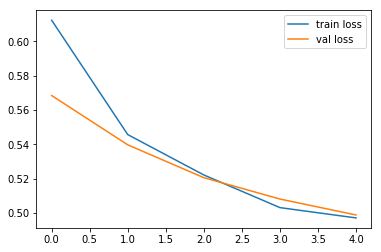

In [25]:
batch_size = 32
epochs = 5
train_model((model, encinf, decinf), train_samples, batch_size=batch_size, epochs=epochs, 
            train_split=0.95, model_name=model_name, max_seq_length=max_seq_length, steps_per_epoch=1000)

In [26]:
max_seq_length = 50
model_name = 'basic_seq2seq_20k_50_300d_1-1_LSTM'
model_file = model_name + '.h5'
# create the model
model, encinf, decinf = define_models_lstm(src_vocab_size=vocab_size, input_shape=(None,), latent_dim=300, embedding_matrix=embedding_matrix,
                             encoder_depth=1, decoder_depth=1, trainable_embeddings=False)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

In [31]:
if os.path.isfile('data/train_test_data_50.pkl'):
    print('Loading saved data...')
    with open('data/train_test_data_50.pkl', mode='rb') as f:
        train_samples, test_samples = pkl.load(f)
else:
    print('Creating samples')
    train_samples, test_samples = create_samples(data, max_seq_length=50, test_split=0)
    with open('data/train_test_data_50.pkl', mode='wb') as f:
        pkl.dump((train_samples, test_samples), f)

print('Train samples:', len(train_samples))
print('Test samples:', len(test_samples))

Train samples: 121867
Test samples: 0


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/5
1000/1000 [==============================] - 1499s 1s/step - loss: 1.9959 - categorical_accuracy: 0.0596 - val_loss: 1.8318 - val_categorical_accuracy: 0.0746

Epoch 00001: val_loss improved from inf to 1.83184, saving model to basic_seq2seq_20k_50_300d_1-1_LSTM.h5


/home/ruc0029/.local/lib/python3.5/site-packages/keras/engine/topology.py:2379: UserWarning: Layer decoder_0 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_0_2/while/Exit_2:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'encoder_0_2/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '



Epoch 00001: saving model to basic_seq2seq_20k_50_300d_1-1_LSTM


/home/ruc0029/.local/lib/python3.5/site-packages/keras/engine/topology.py:2379: UserWarning: Layer decoder_0 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'inference_h_2:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'inference_c_2:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/5
1000/1000 [==============================] - 1493s 1s/step - loss: 1.7264 - categorical_accuracy: 0.0821 - val_loss: 1.6943 - val_categorical_accuracy: 0.0895

Epoch 00002: val_loss improved from 1.83184 to 1.69428, saving model to basic_seq2seq_20k_50_300d_1-1_LSTM.h5

Epoch 00002: saving model to basic_seq2seq_20k_50_300d_1-1_LSTM
Epoch 3/5
1000/1000 [==============================] - 1495s 1s/step - loss: 1.6045 - categorical_accuracy: 0.0954 - val_loss: 1.6025 - val_categorical_accuracy: 0.0996

Epoch 00003: val_loss improved from 1.69428 to 1.60253, saving model to basic_seq2seq_20k_50_300d_1-1_LSTM.h5

Epoch 00003: saving model to basic_seq2seq_20k_50_300d_1-1_LSTM
Epoch 4/5
1000/1000 [==============================] - 1495s 1s/step - loss: 1.5196 - categorical_accuracy: 0.1057 - val_loss: 1.5428 - val_categorical_accuracy: 0.1080

Epoch 00004: val_loss improved from 1.60253 to 1.54282, saving model to basic_seq2seq_20k_50_300d_1-1_LSTM.h5

Epoch 00004: saving model to 

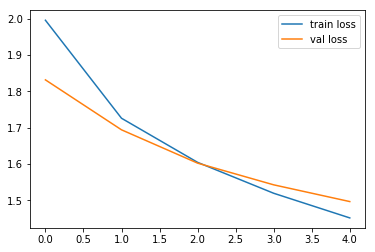

In [33]:
batch_size = 128
epochs = 5
train_model((model, encinf, decinf), train_samples, batch_size=batch_size, epochs=epochs, 
            train_split=0.95, model_name=model_name, max_seq_length=50, steps_per_epoch=1000)

## Attention-based models
Here, we train two basic (1-deep) models as before, parameterized by their sequence length:
* 200-length (better but much slower to train)
* 50-length (much faster to train but less performant)

In addition, they also implement a simple attention mechanism as described in https://arxiv.org/abs/1508.04025 (see also https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html for a nice tutorial). 

In [13]:
max_seq_length = 200
model_name = 'att_seq2seq_20k_200_300d_1-1_LSTM'

# create the model
model, encinf, decinf = define_models_lstm(src_vocab_size=vocab_size, input_shape=(None,), latent_dim=300, 
                                           embedding_matrix=embedding_matrix, encoder_depth=1, decoder_depth=1, 
                                           trainable_embeddings=False, attention=True)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

print('=== Training model ===')
model.summary()
print('\n=== Inference encoder ===')
encinf.summary()
print('\n=== Inference decoder ===')
decinf.summary()

=== Training model ===
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    6000900     masking_1[0][0]      

In [ ]:
if os.path.isfile('data/train_test_data_200.pkl'):
    print('Loading saved data...')
    with open('data/train_test_data_200.pkl', mode='rb') as f:
        train_samples, test_samples = pkl.load(f)
else:
    print('Creatins samples...')
    train_samples, test_samples = create_samples(data, max_seq_length=max_seq_length, test_split=0)
    with open('data/train_test_data_200.pkl', mode='wb') as f:
        pkl.dump((train_samples, test_samples), f)

print('Train samples:', len(train_samples))
print('Test samples:', len(test_samples))

/hpc/sw/python-3.5.2/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/5
1000/1000 [==============================] - 1593s 2s/step - loss: 0.8809 - categorical_accuracy: 0.0234 - val_loss: 0.8452 - val_categorical_accuracy: 0.0300

Epoch 00001: val_loss improved from inf to 0.84519, saving model to att_seq2seq_20k_200_300d_1-1_LSTM.h5


/home/ruc0029/.local/lib/python3.5/site-packages/keras/engine/topology.py:2379: UserWarning: Layer decoder_0 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_0/while/Exit_2:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'encoder_0/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '



Epoch 00001: saving model to att_seq2seq_20k_200_300d_1-1_LSTM


/home/ruc0029/.local/lib/python3.5/site-packages/keras/engine/topology.py:2379: UserWarning: Layer decoder_0 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'inference_h:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'inference_c:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/5
1000/1000 [==============================] - 1605s 2s/step - loss: 0.7943 - categorical_accuracy: 0.0320 - val_loss: 0.7659 - val_categorical_accuracy: 0.0334

Epoch 00002: val_loss improved from 0.84519 to 0.76594, saving model to att_seq2seq_20k_200_300d_1-1_LSTM.h5

Epoch 00002: saving model to att_seq2seq_20k_200_300d_1-1_LSTM
Epoch 3/5
1000/1000 [==============================] - 1596s 2s/step - loss: 0.7655 - categorical_accuracy: 0.0357 - val_loss: 0.7586 - val_categorical_accuracy: 0.0375

Epoch 00003: val_loss improved from 0.76594 to 0.75862, saving model to att_seq2seq_20k_200_300d_1-1_LSTM.h5

Epoch 00003: saving model to att_seq2seq_20k_200_300d_1-1_LSTM
Epoch 4/5
1000/1000 [==============================] - 1601s 2s/step - loss: 0.7365 - categorical_accuracy: 0.0387 - val_loss: 0.7181 - val_categorical_accuracy: 0.0380

Epoch 00004: val_loss improved from 0.75862 to 0.71809, saving model to att_seq2seq_20k_200_300d_1-1_LSTM.h5

Epoch 00004: saving model to att_s

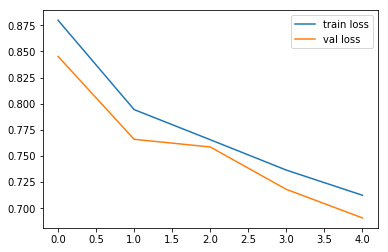

In [19]:
batch_size = 32
epochs = 5
train_model((model, encinf, decinf), train_samples, batch_size=batch_size, epochs=epochs, 
            train_split=0.95, model_name=model_name, steps_per_epoch=1000)

In [221]:
max_seq_length = 50
model_name = 'att_seq2seq_20k_50_300d_1-1_LSTM'

# create the model
model, encinf, decinf = define_models_lstm(src_vocab_size=vocab_size, input_shape=(None,), latent_dim=300, 
                                           embedding_matrix=embedding_matrix, encoder_depth=1, decoder_depth=1, 
                                           trainable_embeddings=False, attention=True)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

print('=== Training model ===')
model.summary()
print('\n=== Inference encoder ===')
encinf.summary()
print('\n=== Inference decoder ===')
decinf.summary()

=== Training model ===
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
masking_24 (Masking)            (None, None)         0           input_47[0][0]                   
                                                                 input_48[0][0]                   
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, None, 300)    6000900     masking_24[0][0]     

In [222]:
if os.path.isfile('data/train_test_data_50.pkl'):
    print('Loading saved data...')
    with open('data/train_test_data_50.pkl', mode='rb') as f:
        train_samples, test_samples = pkl.load(f)
else:
    print('Creating samples')
    train_samples, test_samples = create_samples(data, max_seq_length=50, test_split=0)
    with open('data/train_test_data_50.pkl', mode='wb') as f:
        pkl.dump((train_samples, test_samples), f)

print('Train samples:', len(train_samples))
print('Test samples:', len(test_samples))

Loading saved data...
Train samples: 121867
Test samples: 0


c:\users\daniele\appdata\local\conda\conda\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1/5
1000/1000 [==============================] - 791s 791ms/step - loss: 2.0664 - categorical_accuracy: 0.0539 - val_loss: 1.9883 - val_categorical_accuracy: 0.0675

Epoch 00001: val_loss improved from inf to 1.98830, saving model to att_seq2seq_20k_50_300d_1-1_LSTM.h5


c:\users\daniele\appdata\local\conda\conda\envs\ml\lib\site-packages\keras\engine\network.py:888: UserWarning: Layer decoder_0 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_0_23/while/Exit_2:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'encoder_0_23/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '



Epoch 00001: saving model to att_seq2seq_20k_50_300d_1-1_LSTM


c:\users\daniele\appdata\local\conda\conda\envs\ml\lib\site-packages\keras\engine\network.py:888: UserWarning: Layer decoder_0 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'inference_h_23:0' shape=(?, 300) dtype=float32>, <tf.Tensor 'inference_c_23:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/5
1000/1000 [==============================] - 806s 806ms/step - loss: 1.8871 - categorical_accuracy: 0.0698 - val_loss: 1.8848 - val_categorical_accuracy: 0.0751

Epoch 00002: val_loss improved from 1.98830 to 1.88475, saving model to att_seq2seq_20k_50_300d_1-1_LSTM.h5

Epoch 00002: saving model to att_seq2seq_20k_50_300d_1-1_LSTM
Epoch 3/5
1000/1000 [==============================] - 818s 818ms/step - loss: 1.8381 - categorical_accuracy: 0.0774 - val_loss: 1.8336 - val_categorical_accuracy: 0.0819

Epoch 00003: val_loss improved from 1.88475 to 1.83357, saving model to att_seq2seq_20k_50_300d_1-1_LSTM.h5

Epoch 00003: saving model to att_seq2seq_20k_50_300d_1-1_LSTM
Epoch 4/5
1000/1000 [==============================] - 782s 782ms/step - loss: 1.7744 - categorical_accuracy: 0.0834 - val_loss: 1.7832 - val_categorical_accuracy: 0.0867

Epoch 00004: val_loss improved from 1.83357 to 1.78316, saving model to att_seq2seq_20k_50_300d_1-1_LSTM.h5

Epoch 00004: saving model to att_

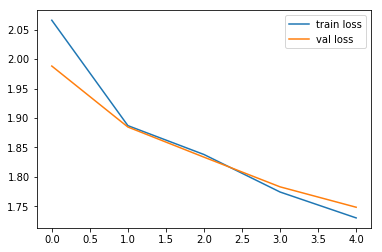

In [225]:
batch_size = 128
epochs = 5
train_model((model, encinf, decinf), train_samples, batch_size=batch_size, epochs=epochs, 
            train_split=0.95, model_name=model_name, steps_per_epoch=1000)

----
# Test
Here we test the models by producing output sentences from a sample input sentence. We provide two type of inference:
* greedy inference (based on argmax sampling)
* beam-search inference (slower but usually giving more realistic results)

In [194]:
def translate_sequence(seq):
    return ' '.join([index_word[int(idx)] for idx in seq])

def prepare_input(input_text, tokenizer):
    return tokenizer.texts_to_sequences([preprocess(input_text)])[0]

def decode_sequence(encinf, decinf, input_seq, vocab_size, max_output_len=50, attention=False):
    # Encode the input as state vectors.
    h, c, encoder_outputs = encinf.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))  # time, features
    # Populate the first word with the eos index (.
    target_seq[0, 0] = eos_index
    
    if attention:
        decoder_inputs = [target_seq, encoder_outputs, h, c]
    else:
        decoder_inputs = [target_seq, h, c]
        
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    i = 1 # number of sampled words
    while not stop_condition:
        output, h, c = decinf.predict(decoder_inputs)
        sampled_word_index = np.argmax(output[0, -1, :])  # batch, time, features
        sampled_word = index_word[sampled_word_index]

        decoded_sentence += sampled_word + ' '
        # Exit condition: either hit max length or find stop character.
        if sampled_word == eos_token or i > max_output_len:
            stop_condition = True     

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_word_index
        i += 1
        
        # Update states
        if attention:
            decoder_inputs = [target_seq, encoder_outputs, h, c]
        else:
            decoder_inputs = [target_seq, h, c]

    return decoded_sentence

def beam_decoder_lstm(encinf, decinf, input_seq, k, vocab_size, max_output_len=50, attention=False, best_only=False):
    # Encode the input as state vectors.
    h, c, encoder_outputs = encinf.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))  # time, features
    # Populate the first word with the eos index.
    target_seq[0,0] = eos_index

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''    
    decoded_sequences = []
    
    if attention:
        decoder_inputs = [target_seq, encoder_outputs, h, c]
    else:
        decoder_inputs = [target_seq, h, c]
    
    # Init Beam Array (decoder inputs, candidate sequence, score)
    alive_beams = [(target_seq, decoder_inputs, 1.0)]
    dead_beams = []
    
    output_len = 1 # number of sampled words
    while not stop_condition:        
        all_candidates = []
        for i in range(len(alive_beams)):  # for each beam, try to append the next predicted word
            # Get the values of the beam
            candidate_seq, decoder_inputs, score = alive_beams[i]
#             print('Extending beam {} [{}]'.format(i+1, translate_sequence(candidate_seq[0])))
            
            # predict the next word and create candidate list
            output, h, c = decinf.predict(decoder_inputs)
            candidate_score_list = output[0][0]
            
            for j in range(len(candidate_score_list)):  # extend the beam one word at a time and compute the score               
                # Add each candidate to the target sequence.
                new_candidate_seq = np.append(candidate_seq, [[j]], axis=1)
                
                target_seq = np.zeros((1, 1))
                target_seq[0, 0] = j
                
                if attention:
                    decoder_inputs = [target_seq, encoder_outputs, h, c]
                else:
                    decoder_inputs = [target_seq, h, c]
                    
                candidate_beam = (new_candidate_seq, decoder_inputs, score*-np.log(candidate_score_list[j]))
                all_candidates.append(candidate_beam)

        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[-1])
        # select k best
        alive_beams = ordered[:k]
        
        # if a beam has the index of the eos, 
        # 1. Add the beam to decoded_sequences, 
        # 2. Remove it from beams 
        # 3. Lower number of beams (k)
        dead_beams = []
        for bindex, (candidate_seq, _, score) in enumerate(alive_beams):
            candidate_seq = candidate_seq[0]
            if candidate_seq[-1] == eos_index:
#                 print('EOS reached for beam [{}]'.format(translate_sequence(candidate_seq)))
                dead_beams.append(bindex)
                k -= 1
                decoded_sequences.append((candidate_seq, score))
                stop_condition = (0 == k)  # no more beams
        
        alive_beams = [beam for bindex, beam in enumerate(alive_beams) if bindex not in dead_beams]
        
        # Exit condition: either each beam got eos or hit max length
        if not stop_condition and output_len > max_output_len:
            # Add the beams that did not have eos so far to the decoded_sequences
            decoded_sequences += alive_beams
            stop_condition = True

        output_len += 1
        
    decoded_sequences = sorted(decoded_sequences, key=lambda beam: beam[1])
        
    decoded_sentences = [(score, [index_word[int(idx)] if idx > 0 else 'NONE' for idx in seq[1:]]) for seq, score in decoded_sequences]
    decoded_sentences = [(score, ' '.join(sentence)) for score, sentence in decoded_sentences]

    if best_only:
        return decoded_sentences[0][1]
    else:
        return decoded_sentences

In [226]:
test_lines = ["""You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
             to be a large living room. examine table""",
             """You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. look""",
              """You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. east""",
              """The wind blows on your face. You can barely feel your right hand It has been three days
              since you left the camp. Or was it four? While you struggle to remember, you spot what
              appears to be the light of a bright beacon to the east. east""",
              """inventory""", 
              """wait"""]

In [227]:
model, encinf, decinf = define_models_lstm(src_vocab_size=vocab_size, input_shape=(None,), latent_dim=300, embedding_matrix=embedding_matrix,
                             encoder_depth=1, decoder_depth=1, trainable_embeddings=False, attention=False)

# load the 200-long model
model_name = 'models/basic_seq2seq_20k_200_300d_1-1_LSTM'
if os.path.isfile(model_name + '.h5'):
    print('Loading weights...')
    encinf.load_weights(model_name + '-encinf.h5')
    decinf.load_weights(model_name + '-decinf.h5')

Loading weights...


In [228]:
for line in test_lines:
    print('IN: {}'.format(line))
    input_seq = prepare_input(line, tokenizer)
    print('OUT: {}'.format(decode_sequence(encinf, decinf, input_seq, vocab_size, max_output_len=50)))

IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
             to be a large living room. examine table
OUT: you are in a small cave a large room with been been been used to use a few feet of the room there is a small room to the north and a small room to the north is a small window leading into the room to the north is a small 
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. look
OUT: you are in a small cave a large room with been been been used to use a few feet of the room there is a small room to the north and a small room to the north is a small window leading into the room to the north is a small 
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of th

In [229]:
for line in test_lines:
    print('IN: {}'.format(line))
    input_seq = prepare_input(line, tokenizer)
    print('OUT: {}'.format(beam_decoder_lstm(encinf, decinf, input_seq, 5, vocab_size, max_output_len=50, best_only=True)))

IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
             to be a large living room. examine table
OUT: you cannot see any such thing you can hear the crashing and clanging of a sword fight coming from the tavern common room EOS
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. look
OUT: you cannot see any such thing you can hear the crashing and clanging of a sword fight coming from the tavern common room EOS
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. east
OUT: you cannot see any such thing you can hear the crashing and clanging of a swo

In [199]:
# load the 50-long model
model_name = 'models/basic_seq2seq_20k_50_300d_1-1_LSTM'
if os.path.isfile(model_name + '.h5'):
    print('Loading weights...')
    encinf.load_weights(model_name + '-encinf.h5')
    decinf.load_weights(model_name + '-decinf.h5')

Loading weights...


In [200]:
for line in test_lines:
    print('IN: {}'.format(line))
    input_seq = prepare_input(line, tokenizer)
    print('OUT: {}'.format(decode_sequence(encinf, decinf, input_seq, vocab_size, max_output_len=50)))

IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
             to be a large living room. examine table
OUT: a UNK of UNK and a UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK tia UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. look
OUT: a UNK of UNK and a UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK tia UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK 
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To 

In [202]:
for line in test_lines:
    print('IN: {}'.format(line))
    input_seq = prepare_input(line, tokenizer)
    print('OUT: {}'.format(beam_decoder_lstm(encinf, decinf, input_seq, 5, vocab_size, max_output_len=50, best_only=True)))

IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
             to be a large living room. examine table
OUT: you can hear the crashing and clanging of a sword fight coming from the tavern common EOS
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. look
OUT: you can hear the crashing and clanging of a sword fight coming from the tavern common EOS
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. east
OUT: you can hear the crashing and clanging of a sword fight coming from the tavern common EOS
IN: inventory
OUT: you EOS
IN: wait
OUT: you EOS


In [203]:
model, encinf, decinf = define_models_lstm(src_vocab_size=vocab_size, input_shape=(None,), latent_dim=300, embedding_matrix=embedding_matrix,
                             encoder_depth=1, decoder_depth=1, trainable_embeddings=False, attention=True)
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

# load the 200-long model
model_name = 'models/att_seq2seq_20k_200_300d_1-1_LSTM'
if os.path.isfile(model_name + '.h5'):
    print('Loading weights...')
    encinf.load_weights(model_name + '-encinf.h5')
    decinf.load_weights(model_name + '-decinf.h5')

Loading weights...


In [204]:
for line in test_lines:
    print('IN: {}'.format(line)) 
    input_seq = prepare_input(line, tokenizer)
    print('OUT: {}'.format(decode_sequence(encinf, decinf, input_seq, vocab_size, max_output_len=50, attention=True)))

IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
             to be a large living room. examine table
OUT: examine me EOS 
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. look
OUT: examine me EOS 
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. east
OUT: examine me EOS 
IN: inventory
OUT: you are not wearing the key EOS 
IN: wait
OUT: wait EOS 


In [206]:
for line in test_lines:
    print('IN: {}'.format(line))
    input_seq = prepare_input(line, tokenizer)
    print('OUT: {}'.format(beam_decoder_lstm(encinf, decinf, input_seq, 5, vocab_size, max_output_len=50, attention=True, best_only=True)))

IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
             to be a large living room. examine table
OUT: south EOS
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. look
OUT: south EOS
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. east
OUT: south EOS
IN: inventory
OUT: look EOS
IN: wait
OUT: wait EOS


In [207]:
# load the 50-long model
model_name = 'models/att_seq2seq_20k_50_300d_1-1_LSTM'
if os.path.isfile(model_name + '.h5'):
    print('Loading weights...')
    encinf.load_weights(model_name + '-encinf.h5')
    decinf.load_weights(model_name + '-decinf.h5')

Loading weights...


In [208]:
for line in test_lines:
    print('IN: {}'.format(line))
    input_seq = prepare_input(line, tokenizer)
    print('OUT: {}'.format(decode_sequence(encinf, decinf, input_seq, vocab_size, max_output_len=50, attention=True)))

IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
             to be a large living room. examine table
OUT: examine me EOS 
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. look
OUT: examine me EOS 
IN: You find yourself in a dimly lit room. Before you you can spot a table. 
On the other side of the room a poster hangs askew on the wall. To the east a door leads to what seems
to be a large living room. east
OUT: examine me EOS 
IN: inventory
OUT: examine bag EOS 
IN: wait
OUT: out EOS 


In [214]:
line = test_lines[0]
input_seq = prepare_input(line, tokenizer)
print('OUT: {}'.format(beam_decoder_lstm(encinf, decinf, input_seq, 5, vocab_size, max_output_len=50, attention=True, best_only=False)))
# for line in test_lines:
#     print('IN: {}'.format(line))
#     input_seq = prepare_input(line, tokenizer)
#     print('OUT: {}'.format(beam_decoder_lstm(encinf, decinf, input_seq, 5, vocab_size, max_output_len=50, attention=True, best_only=True)))

OUT: [(0.009560183054736715, 'inventory EOS'), (0.06043526970614366, 'east EOS'), (1.0097972336216878, 'examine me EOS'), (2.2212223625281133, 'get all EOS'), (3.144422467227716, 'take all EOS')]
